<a href="https://colab.research.google.com/github/pablocontini/Taller-de-Procesamiento-de-Datos/blob/main/TPS08_EM_%2B_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado

**EM+Kmeans**

En el archivo $\texttt{instrumentos.zip}$ encontrará audios de diferentes instrumentos musicales. Se desea clasificar entre las 5 clases de instrumentos presentes en la base de datos.

(a) *Exploración de datos*:

- Utilizando `load` (librosa), construir 5 conjuntos de datos de entrenamiento y 5 de testeo (uno por instrumento). Reservar el último archivo de cada instrumento para el conjunto de testeo, y utilizar el resto para entrenamiento.
- Graficar la señal temporal de testeo de la guitarra en función del tiempo (en segundos).
- Reproducir el audio de testeo de la guitarra utilizando `Audio` (IPyhton).
- Utilizando `ShortTimeFFT` (scipy.signal). Extraer un espectrograma de cada señal. <img src="https://i.ibb.co/tTfkc8DH/image.png" width="25" />: Una buena selección de criterios es utilizar una fft de 64 puntos, un solapamiento del 50\%, descartar la parte simétrica del espectro y utilizar ventana de *hamming* de la misma cantidad de puntos de la fft.

(b) *Entrenamiento*:

- Entrenar 5 algoritmos KMeans (uno por cada instrumento). El código debe estar estructurado de la siguiente manera:

```python
class Kmeans:
  # Inicializar atributos y declarar hiperparámetros
  def __init__(self,...

  # Etapa de entrenamiento
  def fit(self,X):

  # Etapa de testeo
  def predict(self,X):
```

- Utilizando `GaussianMixture` (sklearn), entrenar 5 mezclas de 6 gaussianas diagonales cada una (una por cada instrumento) utilizando el algoritmo EM. Inicializar dicho algoritmo utilizando el Kmeans desarrollado en el ítem anterior. <img src="https://i.ibb.co/tTfkc8DH/image.png" width="25" />: Si bien es evidente que los centroides representan las medias de las gaussianas, no es tan claro pensar como inicializar los pesos y varianzas. Justificar su criterio de inicialización.

(c) *Testeo*:

- Para todas las combinaciones se desea evaluar que tan verosímil es que las muestras de la clase $i$-ésima correspondan al modelo $j$-ésimo. Indicar las *log-verosimilitud* correspondientes en un cuadro de doble entrada del algoritmo EM.

- Cada algoritmo $j$-ésimo define una distribución $p(x\lvert j)$. Asumiendo una probabilidad de cada clase $P(j)$ proporcional a la cantidad de muestras de entrenamiento de cada instrumento, calcular las probabilidades a posteriori a partir de la regla de bayes. Es decir, indicar en un cuadro de doble entrada la probabilidad de la clase $j$-ésima para las muestras correspondientes al instrumento $i$-ésimo $P(j\lvert \mathcal{D_i})$. <img src="https://i.ibb.co/tTfkc8DH/image.png" width="25" />: la función `softmax` (scipy) puede ser útil.

- Sea $x(t)$ la señal correspondiente al audio de testeo de la guitarra. Graficar $\log P\left(j\lvert x(t)\right)$ en función del tiempo, para cada uno de los 5 instrumentos (indexados por $j$).


# (a) Exploración de datos

## Descarga y extracción de los datos


En primer lugar, se descargan y extraen los archivos de audio de instrumentos musicales desde el repositorio GitHub de la materia. El archivo `instrumentos.zip` se obtiene mediante una solicitud HTTP y se descomprime localmente en una carpeta llamada `instrumentos`.

In [ ]:
from pathlib import Path
import requests, zipfile, io, shutil

url = ("https://github.com/mvera1412/TA136-TB056-TB057-8625/raw/"
           "refs/heads/main/data/instrumentos.zip")
dir = Path("instrumentos")

# Realizar una solicitud GET a la URL para descargar el archivo.
# stream=True permite descargar el contenido de forma incremental.
resp = requests.get(url, stream=True)
# Verificar si la solicitud fue exitosa.
resp.raise_for_status()

# Abrir el contenido de la respuesta como un archivo zip (usando io.BytesIO)
with zipfile.ZipFile(io.BytesIO(resp.content)) as zf:
    # Verificar si el directorio de destino ya existe
    if dir.exists():
        # Si existe, eliminarlo y todo su contenido de forma recursiva
        shutil.rmtree(dir)
    # Extraer todo el contenido del archivo zip
    zf.extractall(dir)

# Imprimir la ruta absoluta del directorio
print(f"Directorio: “{dir.resolve()}”.")

Directorio: “/content/instrumentos”.


## Construcción de los conjuntos de datos de entrenamiento y testeo

Una vez obtenidos los archivos de audio`.mp3`, se agrupan por instrumento según el nombre del archivo. Luego, para cada instrumento, se reserva el **último archivo** como muestra de **testeo** y el resto se utiliza como muestras de **entrenamiento**. Cada archivo es cargado usando `librosa` y almacenado en uno de los dos diccionarios: `train_data` y `test_data`.

In [ ]:
import librosa
import os

# Inicializar diccionarios para almacenar los datos de entrenamiento y testeo
train_data = {}
test_data = {}

# Frecuencia de muestreo
sr_target = 44_100

# Obtener una lista ordenada de todos los archivos .mp3
audio_files = sorted(list(dir.glob("*.mp3")))

# Diccionario temporal para agrupar archivos por instrumento
instrument_files = {}

# Agrupar los archivos de audio por instrumento
for audio_file in audio_files:
    # Extraer el nombre del instrumento del nombre base del archivo
    instrument_name = audio_file.stem.split('_')[0]

    # Agregar el archivo a la lista correspondiente al instrumento
    if instrument_name not in instrument_files:
        instrument_files[instrument_name] = []
    instrument_files[instrument_name].append(audio_file)

# Procesar los archivos agrupados por instrumento
for instrument_name, files in instrument_files.items():
    # Verificar si hay archivos para este instrumento
    if files:
        # El último archivo se reserva para testeo
        test_file = files[-1]
        # El resto de los archivos se utilizan para entrenamiento
        train_files = files[:-1]

        # Cargar los archivos de testeo y entrenamiento
        test_data[instrument_name] = librosa.load(test_file, sr=sr_target)[0]
        train_data[instrument_name] = [librosa.load(f, sr=sr_target)[0] for f in files[:-1]]

## Señal temporal de la señal de testeo de la guitarra

A continuación, se **grafica la señal temporal del audio de testeo correspondiente a la guitarra**. Esto permite visualizar cómo varía la forma de onda del sonido a lo largo del tiempo, lo cual es útil para tener una primera impresión de su estructura temporal.



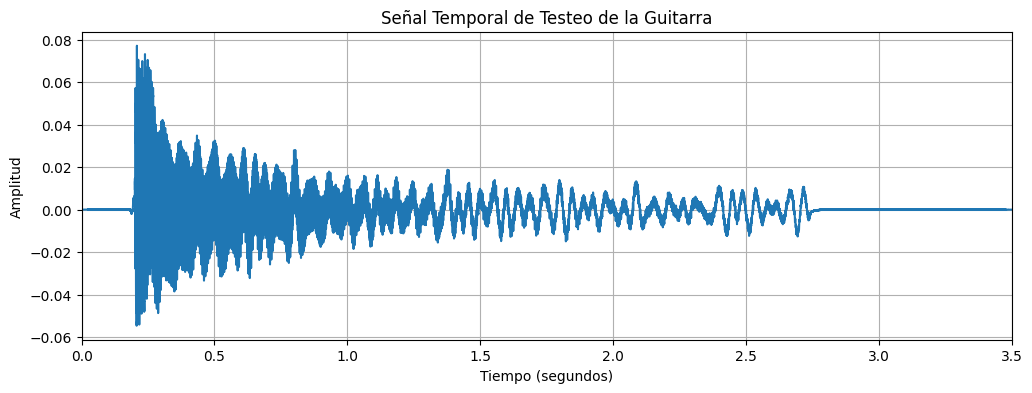

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Obtener los datos de audio de muestreo para la guitarra
audio= test_data['guitar']

# Calcular el eje de tiempo en segundos
t = np.linspace(0, len(audio) / sr_target, len(audio))

# Crear la gráfica
plt.figure(figsize=(12, 4))
plt.plot(t, audio)
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Amplitud")
plt.title("Señal Temporal de Testeo de la Guitarra")
plt.grid(True)
plt.xlim(0, t[-1])
plt.show()

## Audio de testeo de la guitarra

Luego se utiliza la función `Audio` de `IPython.display` para **reproducir el audio de testeo cargado previamente**, en este caso, correspondiente a la guitarra. Esta función, crea un objeto interactivo que permite escuchar la señal directamente desde el entorno de ejecución.

In [ ]:
from IPython.display import Audio

# Crea un objeto Audio que se renderizará como un reproductor de audio.
Audio(data=audio, rate=sr_target)

## Cálculo del espectrograma de cada señal

A continuación, se calculan los **espectrogramas** de todos los audios utilizando la transformada corta de Fourier. Se configura una **ventana de Hamming** de 64 puntos y un **solapamiento del 50\%** entre ventanas.

Para cada señal:
- Se calcula su representación espectral en magnitud con `ShortTimeFFT` (signal).
- Se convierte a **escala logarítmica en decibeles (dB)** para realzar las diferencias de energía.
- Finalmente, se guardan los espectrogramas como **matrices** donde cada fila representa un instante temporal y cada columna una banda de frecuencia.



In [ ]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hamming, get_window

# Parámetros para ShortTimeFFT
n_fft = 64  # 64 puntos para la FFT
hop_length = n_fft // 2  # Solapamiento del 50%
window  = get_window("hamming", n_fft, fftbins=True) # Ventana de Hamming

# Constante pequeña para evitar el logaritmo de cero
epsilon = 1e-20

stft = ShortTimeFFT(
    win=window,
    hop=hop_length,
    fs=sr_target,
    mfft=n_fft,
    fft_mode="onesided",      # descarta la parte simétrica
    scale_to="magnitude"      # magnitud directa
)

# Diccionario para almacenar los espectrogramas de entrenamiento y testeo
X_train = {}
X_test = {}

# Calcular espectrogramas para datos de entrenamiento
for instrument, data_list in train_data.items():
    X_train[instrument] = []
    for audio in data_list:
        spectrogram_magnitude = stft.spectrogram(audio)
        spectrogram_db = 20 * np.log10(spectrogram_magnitude + epsilon)
        X_train[instrument].append(spectrogram_db.T)

# Calcular espectrogramas para datos de testeo
for instrument, audio in test_data.items():
    spectrogram_magnitude = stft.spectrogram(audio)
    spectrogram_db = 20 * np.log10(spectrogram_magnitude + epsilon)
    X_test[instrument] = spectrogram_db.T

# (b) Entrenamiento

**K-means clustering** es un método utilizado para encontrar clústeres y centros de clúster en un conjunto de datos sin etiquetas. El objetivo principal de este procedimiento es minimizar la varianza total dentro de un clúster.

K-means es un procedimiento iterativo. Dado un conjunto de entrenamiento $\left\{x^{(1)},\dots x^{n}\right\}$, para usarlo, se elige primero la cantidad deseada de centros de clúster $k$.

Luego, dado un conjunto inicial de centros $\mu_1, \mu_2,\dots \mu_k \in \mathbb{R}^d$, el algoritmo K-means alterna entre dos pasos principales:
- Para cada centro, se identifica el subconjunto de puntos de entrenamiento (su clúster) que está más cerca de él que de cualquier otro centro. Equivalentemente, para cada punto se identifica el centro más cercano:
$$c^{(i)}:=\arg\min_j\left\lVert x^{(i)}-\mu_j\right\rVert^2$$
- Se calculan las medias de cada característica para los puntos de datos en cada clúster, y este vector de media se convierte en el nuevo centro para ese clúster.
$$\mu_j:=\frac{\sum_{i=1}^n \mathbf{1}\left\{c^{(i)}=j\right\}x^{(i)}}{\sum_{i=1}^n \mathbf{1}\left\{c^{(i)}=j\right\}}$$

Este algoritmo **garantiza la convergencia** en cierto sentido. Si se define la función de distorsión:
$$J(c,\mu)=\sum_{i=1}^n\left\lVert x^{(i)}-\mu_{c^{(i)}}\right\rVert^2$$

Esto es, $J$ mide la suma del cuadrado de las distancias entre cada muestra $x^{(i)}$ y el centroide asignado $\mu_{c^{(i)}}$. Luego, se puede demostrar que K-means es un descenso de coordenadas sobre $J$. Específicamente, el bucle interno minimiza $J$ respecto a $c$ manteniendo $\mu$ fijo, y luego minimiza $J$ con respecto a $\mu$ manteniendo $c$ fijo. Entonces, $J$ debe disminuir monótonamente y el valor de $J$ debe converger (En teoría puede oscilar, pero esto casi nunca sucede en la práctica).

La función distorsión $J$ es una función no convexa, por lo que **no está garantizado que $J$ converja a un mínimo global**. En otras palabras, K-means puede ser susceptible a un óptimo local. Una práctica común es ejecutar K-means muchas veces usando valores iniciales distintos. Luego, de todos los diferentes resultados obtenidos, elegir el que da la distorsión menor $J(c,\mu)$.



## Implementación de K-means

A continuación, se define una clase personalizada de `KMeans` que implementa el algoritmo de clustering con soporte para múltiples inicializaciones (`n_init`). Es decir, el algoritmo se ejecutará múltiples veces con diferentes inicializaciones aleatorias y se guarda la solución con **menor distorsión** (mejor agrupamiento). Esto evita quedarse atrapado en un mal mínimo local.

Los métodos de la clase son:
- `__init__(...)`: Constructor que inicializa los hiperparámetros del modelo:
  - `n_clusters`: número de clústeres deseados.
  - `max_iter`: máximo de iteraciones por ejecución.
  - `tol`: tolerancia para determinar convergencia.
  - `random_state`: permite resultados reproducibles.
  - `n_init`: número de veces que se repite el algoritmo con distintas inicializaciones.
- `fit(X)`: Entrena el modelo sobre un conjunto de datos.
  - Inicializa los centroides aleatoriamente.
  - Repite los pasos de asignación y actualización hasta que converge (o alcanza `max_iter`).
  - Calcula la distorsión (suma de distancias cuadradas a los centroides).
  - Al final, conserva la ejecución con menor distorsión.
- `predict(X)`: Asigna nuevas muestras a los clústeres existentes.
  - Calcula la distancia de cada muestra a los centroides entrenados.
  - Devuelve un array con el índice del clúster más cercano para cada muestra.
  - Este método no modifica los centroides, solo realiza asignación.

Esta implementación se utilizará para realizar una inicialización del modelo probabilístico EM en mezcla de gaussianas, en donde una buena estimación inicial de los centroides puede mejorar la convergencia del modelo.



In [ ]:
from numpy.linalg import norm

class KMeans:
    """
    Implementación del algoritmo de clustering K-Means
    """
    def __init__(self, n_clusters, max_iter=100, tol=1e-4, random_state=None, n_init=100):
        """
        Inicializa el objeto de clustering KMeans.

        Args:
          n_clusters (int): Número de clústeres a formar.
          max_iter (int, opcional): Número máximo de iteraciones por cada inicialización. Por defecto es 100.
          tol (float, opcional): Tolerancia para la convergencia. El algoritmo se detiene si el cambio
                                 en los centros es menor que este valor. Por defecto es 1e-4.
          random_state (int o None, opcional): Determina la generación de números aleatorios
                                              para la inicialización de centroides. Por defecto es None.
          n_init (int, opcional): Número de veces que se ejecutará el algoritmo K-Means con diferentes
                                 semillas de centroides. El resultado final será el mejor en términos
                                 de distorsión. Por defecto es 1.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        # Para generar semillas para cada ejecución de n_init
        self.random_state = np.random.RandomState(random_state)
        self.n_init = n_init # Nuevo parámetro n_init
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None # Atributo para almacenar la distorsión del mejor resultado

    def fit(self, X):
        """
        Calcula el clustering de k-means n_init veces y selecciona el mejor resultado.

        Args:
          X (numpy.ndarray): Los datos de entrada a agrupar, con forma (n_muestras, n_características).

        Returns:
          self: El objeto KMeans ajustado.
        """
        n_samples, n_features = X.shape

        # Inicializa la mejor distorsión con infinito
        best_inertia = np.inf
        best_centers = None
        best_labels = None

        # Bucle exterior para ejecutar el algoritmo n_init veces
        for run in range(self.n_init):
            # Generar una semilla diferente para cada ejecución
            current_random_state = np.random.RandomState(self.random_state.randint(0, 2**32 - 1) if self.random_state else None)

            # Inicializar centroides aleatoriamente para esta ejecución
            centers = X[current_random_state.choice(n_samples, size=self.n_clusters, replace=False)]

            # Algoritmo KMeans para esta ejecución (bucle interior)
            for _ in range(self.max_iter):
                # Paso de Asignación
                distances = norm(X[:, None, :] - centers[None, :, :], axis=2)
                labels = np.argmin(distances, axis=1)

                # Paso de Actualización
                new_centers = np.array(
                    [X[labels == j].mean(axis=0) if np.any(labels == j) else centers[j]
                     for j in range(self.n_clusters)]
                )

                # Verificar convergencia
                shift = norm(new_centers - centers, axis=1).mean()
                centers = new_centers

                if shift < self.tol:
                    break
                else:
                    pass

            # Calcular la distorsión para esta ejecución
            # Suma de distancias cuadradas de cada punto a su centroide asignado
            current_inertia = np.sum(norm(X - centers[labels], axis=1)**2)

            # Comparar con la mejor distorsión encontrada hasta ahora
            if current_inertia < best_inertia:
                best_inertia = current_inertia
                best_centers = centers.copy() # Usar .copy() para evitar problemas de referencia
                best_labels = labels.copy() # Usar .copy()

        # Almacenar los resultados del mejor ciclo
        self.cluster_centers_ = best_centers
        self.labels_ = best_labels
        self.inertia_ = best_inertia # Almacenar la distorsión del mejor resultado

        return self

    def predict(self, X):
        """
        Predice el índice de clúster para cada muestra en los datos de entrada.

        Args:
          X (numpy.ndarray): Los datos de entrada para los que se predice los clústeres,
                             con forma (n_muestras, n_características).

        Returns:
          numpy.ndarray: Un array de índices de clúster, con forma (n_muestras,).
        """
        # Asigna cada punto de datos en X al clúster con el centro más cercano.
        return np.argmin(norm(X[:, None, :] - self.cluster_centers_[None, :, :], axis=2), axis=1)

## Entrenamiento de 5 algoritmos KMeans

A continuación, se entrena un modelo **KMeans independiente para cada instrumento**, utilizando los espectrogramas de entrenamiento previamente calculados. Para cada instrumento:
- Se concatenan todos los espectrogramas en una única matriz de muestras.
- Se entrena un modelo `KMeans` con 6 clústeres, lo que permite capturar distintas regiones espectrales características del instrumento.
- Cada modelo se almacena en un diccionario `kmeans_models` indexado por el nombre del instrumento.


In [ ]:
kmeans_models = {}
n_clusters_per_instrument = 6
default_tolerance = 1e-20 # Definir una tolerancia por defecto

for instrument, spectrogram_list in X_train.items():
    # Concatenar espectrogramas para cada instrumento
    concatenated_spectrograms = np.concatenate(spectrogram_list, axis=0)

    # Inicializar y entrenar un modelo KMeans para el instrumento actual
    kmeans_models[instrument] = KMeans(n_clusters=n_clusters_per_instrument, max_iter=1000, tol=default_tolerance, random_state=42)
    kmeans_models[instrument].fit(concatenated_spectrograms)


## GaussianMixture

Un **Modelo de Mezcla Gaussiana (GMM)** es una forma de modelar densidades de probabilidad complejas que no pueden ser representadas adecuadamente por una única distribución Gaussiana. Se define como una superposición lineal o combinación de $K$ densidades Gaussianas.

Cada componente de la mezcla es una distribución Gaussiana multivariada $\mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ con su propia media $\boldsymbol{\mu}_k$ y matriz de covarianza $\boldsymbol{\Sigma}_k$. Los parámetros del modelo incluyen los parámetros de cada componente Gaussiana y los coeficientes de mezcla $\pi_k$, que representan los pesos de cada componente en la mezcla.

Los GMMs se pueden interpretar en términos de variables latentes discretas. Para cada punto de datos, se asume una variable latente que indica qué componente de la mezcla fue responsable de generarlo. Esta visión permite formar distribuciones complicadas a partir de componentes más simples.

La estimación de los parámetros de un GMM a partir de datos observados se realiza típicamente utilizando el método de Máxima Verosimilitud (MV). Sin embargo, la maximización directa de la función de verosimilitud es difícil debido a una suma dentro del logaritmo y el enfoque de MV presenta problemas de singularidades y múltiples máximos locales. Para abordar esto, se utiliza comúnmente el algoritmo **EM (Expectation-Maximization)**, que es un esquema iterativo.
-El **paso E (Expectación)** calcula las **responsabilidades**, que son las probabilidades a posteriori de que cada punto de datos pertenezca a cada componente, dadas las estimaciones actuales de los parámetros.
- El **paso M (Maximización)** reestima los parámetros del modelo utilizando estas responsabilidades calculadas en el paso E.

Existe una relación entre el EM para GMMs y el algoritmo K-means. K-means es una técnica de agrupamiento no probabilística,  mientras que el EM para GMMs puede verse como una versión "suave" de K-means. De hecho, K-means se utiliza a menudo para inicializar el EM para GMMs.



## Entrenamiento de 5 mezclas de 6 gaussianas diagonales para cada instrumento

A continuación, se entrena un modelo GMM por instrumento musical, utilizando el algoritmo de **Expectation-Maximization (EM)**. Cada modelo representa el espectro de un instrumento como una mezcla de 6 gaussianas diagonales.

El proceso es el siguiente:
- **Preparación de los datos**: Se concatenan los espectrogramas de entrenamiento.
- **Inicialización**: basada en KMeans.
  - Las **medias iniciales** son los centroides del modelo KMeans entrenado previamente.
  - Los **pesos iniciales** se calculan como la proporción de muestras de entrenamiento asignadas a cada clúster.
  - Las **varianzas** (usadas como covarianzas diagonales, con varianza en la diagonal y ceros en el resto) se obtienen como la varianza poblacional intra-clúster de cada grupo de muestras. Si un clúster no tiene muestras suficientes (2) se usa un valor mínimo para evitar divisiones por cero.
- **Entrenamiento del modelo**: Se utiliza `GaussianMixture` (sklearn) con:
  - `covariance_type='diag'` para usar matrices de covarianza diagonales (una por componente).
  - `init_params='random'` combinado con `means_init`, `weights_init` y `precisions_init` para forzar una inicialización basada en KMeans.
  - `precisions_init` que es la inversa de las varianzas diagonales.
  - `reg_covar=1` para evitar problemas numéricos si alguna varianza es muy pequeña.



In [ ]:
from sklearn.mixture import GaussianMixture

# Diccionario para almacenar los modelos GaussianMixture entrenados
gmm_models = {}
# 6 Gaussianas por instrumento
n_components_per_instrument = 6


for instrument, spectrogram_list in X_train.items():
    # Concatenar espectrogramas para el entrenamiento del GMM
    concatenated_spectrograms = np.concatenate(spectrogram_list, axis=0)

    # Obtener los centroides de KMeans entrenado para este instrumento
    kmeans_model = kmeans_models[instrument]
    kmeans_centroids = kmeans_model.cluster_centers_

    # Obtener las etiquetas asignadas por KMeans
    kmeans_labels = kmeans_model.labels_

    # Inicialización para GaussianMixture
    # Las medias (means_) se inicializan con los centroides de KMeans
    initial_means = kmeans_centroids

    # Criterio de inicialización para pesos: Usar la proporción de puntos asignados por KMeans
    weights_init = np.bincount(kmeans_labels, minlength=n_components_per_instrument) / len(kmeans_labels)
    weights_init = np.maximum(weights_init, 1e-6) # Evitar pesos cero que causen problemas numéricos
    weights_init /= weights_init.sum() # Normalizar para que sumen 1

    # Criterio de inicialización para covarianzas (diagonal): Usar la varianza de los puntos asignados por KMeans
    initial_covariances = np.empty((n_components_per_instrument, concatenated_spectrograms.shape[1]))
    for k in range(n_components_per_instrument):
        points_in_cluster = concatenated_spectrograms[kmeans_labels == k]
        if points_in_cluster.shape[0] > 1: # Necesita al menos 2 puntos para calcular varianza
             # Calcular la varianza a lo largo de cada característica para los puntos en el cluster k
            initial_covariances[k, :] = points_in_cluster.var(axis=0)
        else:
            # Si el cluster tiene 0 o 1 punto, usar una pequeña varianza diagonal
            initial_covariances[k, :] = 1e-6


    # Inicializar y entrenar el modelo GaussianMixture
    gmm = GaussianMixture(
        n_components=n_components_per_instrument,
        covariance_type='diag', # Componentes Gaussianos diagonales
        init_params='random',   # Inicializar con KMeans (proporcionando init_means/weights/precisions)
        means_init=initial_means,
        weights_init=weights_init,
        precisions_init=1.0 / initial_covariances,  # precision = 1 / variance
        max_iter=2000,          # Número máximo de iteraciones del algoritmo EM
        tol=1e-20,
        reg_covar=1
    )

    # Entrenar el modelo GMM en los datos
    # Nota: Aunque pasamos inicializaciones, fit() aún corre el algoritmo EM
    gmm.fit(concatenated_spectrograms)

    # Almacenar el modelo GMM entrenado
    gmm_models[instrument] = gmm

# (c) Testeo

## Evaluación de la Log-Verosimilitud

Cada modelo entrenado $j$ define una distribución de probabilidad condicional $p(x\lvert j)$ sobre las muestras de entrada $x$.

Para evaluar el rendimiento del modelo, se calcula la **log-verosimilitud total** que asigna cada modelo $j$ a las muestras de testeo correspondientes a una clase real $i$:
$$\log p\left(\mathcal{D}_i\lvert j\right)=\sum_{x\in\mathcal{D}_i}\log p(x\lvert j)$$
Donde:
- $\mathcal{D}_i$ es el conjunto de muestras de testeo de la clase real $i$.
- $j$ es el modelo (clase predicha).

El resultado se representa en un cuadro de doble entrada, con filas $i$ y columnas $j$.

A partir de los resultados se observa que, para cada conjunto de testeo, el modelo correspondiente a su clase real es el asigna mayor log-verosimilitud. Esto muestra que el entrenamiento con MMG logró capturar de manera adecuada la distribución de características de cada instrumento.



In [ ]:
import pandas as pd

# Diccionario para almacenar los log-verosimilitudes
log_likelihoods = {}

# Iterar sobre cada modelo GMM entrenado (clase predicha j)
for model_instrument, gmm_model in gmm_models.items():
    log_likelihoods[model_instrument] = {}
    # Iterar sobre cada conjunto de datos de testeo (clase real i)
    for test_instrument, test_data_spectrogram in X_test.items():
        # Calcular la log-verosimilitud del conjunto de testeo 'test_instrument'
        log_likelihood_per_frame = gmm_model.score_samples(test_data_spectrogram)
        total_log_likelihood = np.sum(log_likelihood_per_frame)
        log_likelihoods[model_instrument][test_instrument] = total_log_likelihood

# Crear un DataFrame de Pandas para mostrar los resultados en un cuadro de doble entrada
# Transponer para tener modelos en columnas y test data en filas
log_likelihoods_df = pd.DataFrame(log_likelihoods).T

# Renombrar los índices y columnas para mayor claridad
log_likelihoods_df.index.name = 'Modelo GMM (Clase Predicha)'
log_likelihoods_df.columns.name = 'Datos de Testeo (Clase Real)'

display(log_likelihoods_df)

Datos de Testeo (Clase Real),clarinet,guitar,saxophone,trumpet,violin
Modelo GMM (Clase Predicha),,,,,
clarinet,-373835.365755,-835586.862607,-209736.850293,-455795.986548,-387331.749381
guitar,-481351.976765,-623014.755102,-280646.171748,-580620.614915,-421846.614851
saxophone,-395938.745633,-785579.522168,-200131.667787,-459658.221772,-340154.117556
trumpet,-407574.540277,-830646.875316,-215060.894736,-452666.162543,-345084.163030
violin,-426138.994702,-789512.052194,-221507.755760,-508567.479624,-297593.279542


## Probabilidades a posteriori

Para un conjunto de muestras de testeo $\mathcal{D}_i=\{x_1,\dots,x_n\}$ pertenecientes a la clase real $i$, se desea calcular la **probabilidad a posteriori** de que hayan sido generadas por el modelo $j$. Esta probabilidad se obtiene mediante la **Regla de Bayes**:
$$P(j\lvert \mathcal{D}_i)=\frac{P(\mathcal{D_i}\lvert j)\,P(j)}{\sum_k P(\mathcal{D_i}\lvert k)\,P(k)}$$
donde:
- $P(j)$ es la **probabilidad a priori** de la clase $j$.
- $P(\mathcal{D_i}\lvert j)=\prod_{x\in\mathcal{D}_i} p(x\lvert j)$ es la verosimilitud total de los datos bajo el modelo $j$.
- El denominador es el normalizador.

Como trabajar directamente con productos de probabilidades puede ser numérica mente inestable se utiliza su versión en logaritmos:
$$\log P(j\lvert \mathcal{D}_i)=\log P(\mathcal{D_i}\lvert j)+\log P(j)-\log \sum_k e^{\log P(\mathcal{D}_i\lvert k)+\log P(k)}$$
y luego se aplica:
$$P(j\lvert \mathcal{D}_i)=e^{\log P(j\lvert \mathcal{D}_i)}$$

A partir de los resultados se observa que el sistema clasifica correctamente en cada caso, asignando probabilidad 1 a la clase correcta. Esto es coherente con lo visto en el análisis de máxima verosimilitud.



In [ ]:
from scipy.special import logsumexp
import pandas as pd

# Calcular Probabilidades a Priori P(j) basadas en el número de frames
# Contar el número total de frames de espectrograma para cada instrumento en los datos de entrenamiento
train_frame_counts = {}
for instrument, spectrogram_list in X_train.items():
    # Concatenar espectrogramas para obtener el número total de frames para el instrumento
    concatenated_spectrograms = np.concatenate(spectrogram_list, axis=0)
    train_frame_counts[instrument] = concatenated_spectrograms.shape[0] # Contar frames (filas)

# Calcular el número total de frames de entrenamiento en todos los instrumentos
total_train_frames = sum(train_frame_counts.values())

# Calcular las probabilidades a priori P(j)
prior_probabilities = {instrument: count / total_train_frames for instrument, count in train_frame_counts.items()}


# Convertir las probabilidades a priori a probabilidades logarítmicas (log P(j))
log_prior_probabilities = {instrument: np.log(prob) for instrument, prob in prior_probabilities.items()}


# Calcular log P(Data_i | j) + log P(j)
# log_likelihoods_df contiene total_log_likelihood = suma(log P(x_k | j)) para todas las muestras x_k en el conjunto de prueba i y el modelo j

# Diccionario para almacenar los numeradores logarítmicos de la probabilidad a posteriori
# log(P(Data_i | j) * P(j)) = log(P(Data_i | j)) + log(P(j))
log_posterior_numerators = {}

for model_instrument in gmm_models.keys(): # Iterar sobre las clases predichas (j)
    log_posterior_numerators[model_instrument] = {}
    for test_instrument in X_test.keys(): # Iterar sobre las clases reales (i)
        # Obtener la log-verosimilitud total para el conjunto de prueba 'test_instrument' bajo el modelo 'model_instrument'
        total_log_likelihood = log_likelihoods_df.loc[model_instrument, test_instrument]

        # Sumar la probabilidad logarítmica a priori de la clase del modelo (j)
        log_prior_j = log_prior_probabilities[model_instrument]

        # Almacenar log P(Data_i | j) + log P(j)
        log_posterior_numerators[model_instrument][test_instrument] = total_log_likelihood + log_prior_j

# Convertir a DataFrame
log_posterior_numerators_df = pd.DataFrame(log_posterior_numerators).T

# Calcular las probabilidades a posteriori P(j | Data_i) para cada conjunto de prueba (i)
# P(j | Data_i) = exp(log P(Data_i | j) + log P(j)) / suma_k(exp(log P(Data_i | k) + log P(k)))
# Usando log-sum-exp para estabilidad numérica:
# log P(j | Data_i) = (log P(Data_i | j) + log P(j)) - log(suma_k(exp(log P(Data_i | k) + log P(k))))
# P(j | Data_i) = exp(log P(j | Data_i))

# Diccionario para almacenar las probabilidades a posteriori P(j | Data_i)
posterior_probabilities = {}

# Iterar sobre las clases reales (i) (conjuntos de prueba)
for test_instrument in log_posterior_numerators_df.columns:
    # Obtener los numeradores logarítmicos de la probabilidad a posteriori para el conjunto de prueba actual en todos los modelos
    log_numerators_for_dataset = log_posterior_numerators_df[test_instrument].values

    # Calcular la evidencia logarítmica para el conjunto de prueba actual usando log-sum-exp
    # log P(Data_i) = log(suma_k(exp(log P(Data_i | k) + log P(k))))
    log_evidence = logsumexp(log_numerators_for_dataset)

    # Calcular las probabilidades logarítmicas a posteriori: log P(j | Data_i) = log(numerador_j) - log(evidencia)
    log_posterior_for_dataset = log_numerators_for_dataset - log_evidence

    # Calcular las probabilidades a posteriori reales exponenciando las logarítmicas
    probabilities_for_dataset = np.exp(log_posterior_for_dataset)

    # Almacenar las probabilidades con los nombres de los instrumentos del modelo como claves
    posterior_probabilities[test_instrument] = dict(zip(log_posterior_numerators_df.index, probabilities_for_dataset))


# Crear un DataFrame para las probabilidades a posteriori
# Transponer para el formato deseado (Datos de Prueba como filas, Modelo GMM como columnas)
posterior_probabilities_df = pd.DataFrame(posterior_probabilities).T

# Renombrar índices y columnas para mayor claridad
posterior_probabilities_df.index.name = 'Datos de Testeo (Clase Real)'
posterior_probabilities_df.columns.name = 'Modelo GMM (Clase Predicha)'

print("\nCuadro de Probabilidades a Posteriori P(j | Datos de Testeo i):")
display(posterior_probabilities_df.round(8))


Cuadro de Probabilidades a Posteriori P(j | Datos de Testeo i):


Modelo GMM (Clase Predicha),clarinet,guitar,saxophone,trumpet,violin
Datos de Testeo (Clase Real),,,,,
clarinet,1.0,0.0,0.0,0.0,0.0
guitar,0.0,1.0,0.0,0.0,0.0
saxophone,0.0,0.0,1.0,0.0,0.0
trumpet,0.0,0.0,0.0,1.0,0.0
violin,0.0,0.0,0.0,0.0,1.0


## $\log P\left(j\lvert x(t)\right)$ en función del tiempo para el audio de testeo de la guitarra

A continuación, se analiza, en función del tiempo, **qué tan probable es que cada frame del audio de testeo de guitarra haya sido generado por cada uno de los modelos $j$**. Para eso se calcula:
$$\log P\left(j\lvert x(t)\right)$$
donde:
- $x(t)$ es un frame del espectrograma extraído del audio en el instante $t$.
- $P\left(j\lvert x(t)\right)$ es la probabilidad a posteriori de que el modelo $j$ haya generado ese frame.

Este análisis permite ver **cómo cambia la confianza del modelo sobre la clase del sonido a lo largo del tiempo**.

A partir de los resultados se observa lo siguiente:
- Para el modelo clarinet $\log P\left(j\lvert x(t)\right)$ se mantiene entre -20 y -100 durante gran parte del audio, por lo tanto no hay indicios de que pueda confundir la guitarra con el clarinete.
- Para el modelo guitar casi todo el tiempo $\log P\left(j\lvert x(t)\right)\simeq 0$ (hay caídas breves, pero rápidamente vuelve a 0). Por lo tanto, hay una alta confianza constante del modelo. Éste identifica la guitarra correctamente en casi todo momento.
- Para el modelo saxophone $\log P\left(j\lvert x(t)\right)$ se mantiene casi todo el tiempo entre -25 y -80. Hay leve similitud espectral con la guitarra pero sin riesgo de confusión.
- Para el modelo trumpet el comportamiento es similar al de clarinet. El modelo no confunde guitarra con trompeta.
- Para el modelo violín hay una elevación en la zona central del audio, pero sigue sin acercarse a cero. Hay una similitud con ciertas características de la guitarra (tal vez porque ambos son instrumento de cuerdas) pero la clasificación sigue siendo correcta.




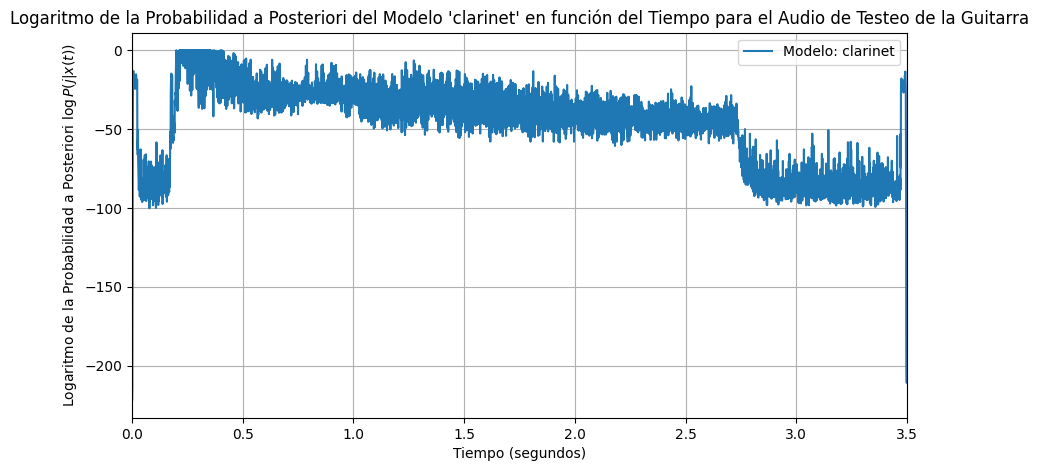

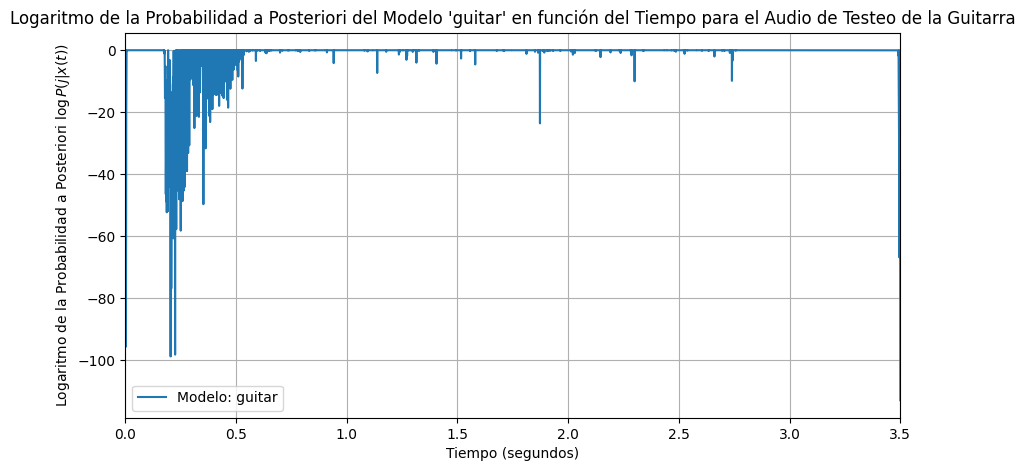

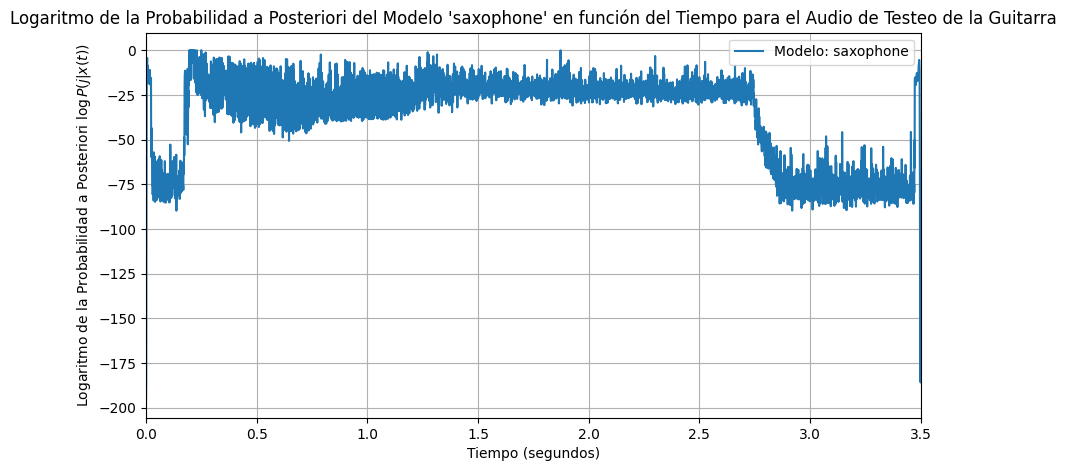

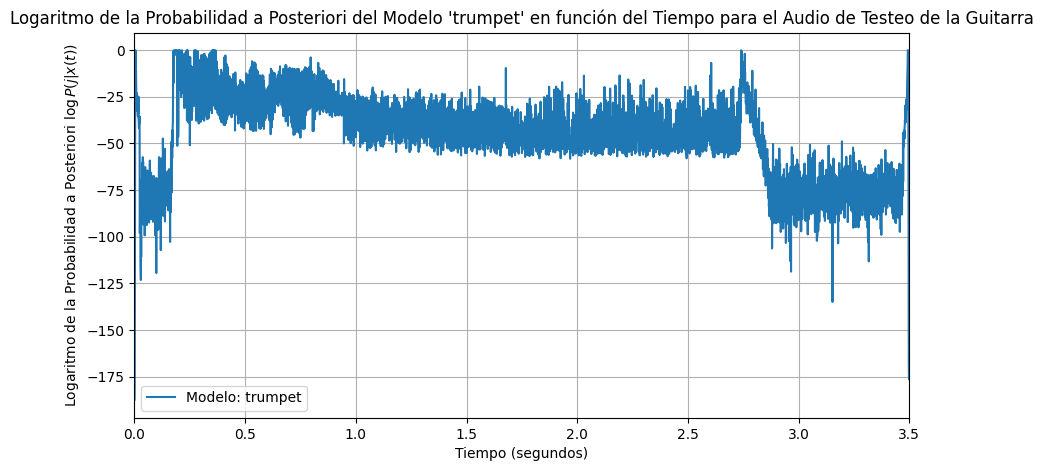

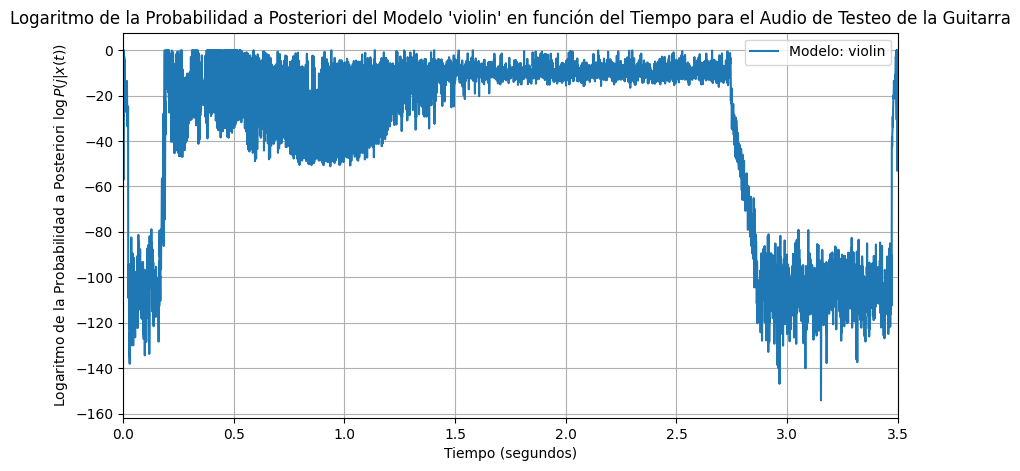

In [ ]:
# Seleccionar el audio de prueba para la guitarra
guitar_test_audio = test_data['guitar']

# Obtener el espectrograma
guitar_test_spectrogram = X_test['guitar']

# Calcular log P(x(t) | j) para cada x(t) y cada modelo j
log_likelihoods_per_frame = {}
for model_instrument, gmm_model in gmm_models.items():
    log_likelihoods_per_frame[model_instrument] = gmm_model.score_samples(guitar_test_spectrogram)


# Convertir el diccionario en un DataFrame de pandas
log_likelihoods_per_frame_df = pd.DataFrame(log_likelihoods_per_frame)


# Calcular log P(x(t) | j) + log P(j) para cada frame y para cada modelo
log_numerator_per_frame = log_likelihoods_per_frame_df + pd.Series(log_prior_probabilities)


# Calcular log P(x(t)) para cada frame usando logsumexp
# log P(x(t)) es la evidencia para ese frame específico
log_evidence_per_frame = logsumexp(log_numerator_per_frame.values, axis=1)


# Calcular log P(j | x(t)) para cada frame y para cada modelo
# log P(j | x(t)) = (log P(x(t) | j) + log P(j)) - log P(x(t))
log_posterior_per_frame = log_numerator_per_frame.subtract(log_evidence_per_frame, axis=0)


# Graficar log P(j | x(t)) en función del tiempo

# Obtener el número de frames en el espectrograma de prueba de guitarra
n_frames = guitar_test_spectrogram.shape[0]

# Calcular el tiempo de cada frame
time_per_frame = np.arange(n_frames) * hop_length / sr_target

# Iterar a través de las probabilidades posteriores logarítmicas de cada modelo
for model_instrument in log_posterior_per_frame.columns:
    # Crear una nueva figura
    plt.figure(figsize=(10, 5))

    # Graficar log P(j | x(t)) para el modelo de instrumento actual (j)
    plt.plot(time_per_frame, log_posterior_per_frame[model_instrument], label=f'Modelo: {model_instrument}')

    plt.xlabel("Tiempo (segundos)")
    plt.ylabel("Logaritmo de la Probabilidad a Posteriori $\log P(j | x(t))$")
    plt.title(f"Logaritmo de la Probabilidad a Posteriori del Modelo '{model_instrument}' en función del Tiempo para el Audio de Testeo de la Guitarra")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, time_per_frame[-1])
    plt.show()